# Clustering with K-means

## Understanding centroid-based algorithms

In [1]:
import numpy as np
A = np.array([165, 55, 70])
B = np.array([185, 60, 30])

D = (A - B)
D = D**2
D = np.sqrt(np.sum(D))

print(D)

45.0


## Creating an example with image data

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
ground_truth = digits.target

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
pca = PCA(n_components=30)
Cx = pca.fit_transform(scale(X))
print('Explained variance %0.3f' 
      % sum(pca.explained_variance_ratio_))

Explained variance 0.893


In [4]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=10, 
                    n_init=10, random_state=1)
clustering.fit(Cx)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

## Looking for optimal solutions

In [5]:
import numpy as np
import pandas as pd
ms = np.column_stack((ground_truth,clustering.labels_))
df = pd.DataFrame(ms, 
                  columns = ['Ground truth','Clusters'])
pd.crosstab(df['Ground truth'], df['Clusters'], 
            margins=True)

Clusters,0,1,2,3,4,5,6,7,8,9,All
Ground truth,,,,,,,,,,,
0,0,0,0,0,0,177,0,1,0,0,178
1,96,0,27,0,0,0,58,1,0,0,182
2,40,80,46,1,6,0,4,0,0,0,177
3,8,7,1,7,160,0,0,0,0,0,183
4,2,1,0,4,0,0,7,158,0,9,181
5,17,70,0,6,78,0,3,4,4,0,182
6,4,0,0,0,0,1,1,0,175,0,181
7,0,8,0,151,0,0,3,0,0,17,179
8,99,11,0,2,44,0,15,0,3,0,174


In [6]:
import numpy as np
inertia = list()
for k in range(1,21):
    clustering = KMeans(n_clusters=k, 
                        n_init=10, random_state=1)
    clustering.fit(Cx)
    inertia.append(clustering.inertia_)
delta_inertia = np.diff(inertia) * -1

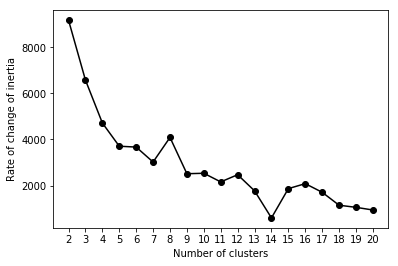

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
x_range = [k for k in range(2, 21)]
plt.xticks(x_range)
plt.plot(x_range, delta_inertia, 'ko-')
plt.xlabel('Number of clusters')
plt.ylabel('Rate of change of inertia')
plt.show()

## Clustering big data

In [8]:
k = 10
clustering = KMeans(n_clusters=k, 
                    n_init=10, random_state=1)
clustering.fit(Cx)
kmeans_inertia = clustering.inertia_
print("K-means inertia: %0.1f" % kmeans_inertia)

K-means inertia: 57893.5


In [9]:
from sklearn.cluster import MiniBatchKMeans
batch_clustering = MiniBatchKMeans(n_clusters=k, 
                                   random_state=1)
batch = 100
for row in range(0, len(Cx), batch):
    if row+batch < len(Cx):
        feed = Cx[row:row+batch,:]
    else:
        feed = Cx[row:,:]
    batch_clustering.partial_fit(feed)
batch_inertia = batch_clustering.score(Cx) * -1

print("MiniBatchKmeans inertia: %0.1f" % batch_inertia)

MiniBatchKmeans inertia: 64671.9


# Performing Hierarchical Clustering

## Using a hierarchical cluster solution

In [10]:
from sklearn.cluster import AgglomerativeClustering

Hclustering = AgglomerativeClustering(n_clusters=10, 
                               affinity='euclidean', 
                               linkage='ward')
Hclustering.fit(Cx)

ms = np.column_stack((ground_truth,Hclustering.labels_))
df = pd.DataFrame(ms, 
                  columns = ['Ground truth','Clusters'])
pd.crosstab(df['Ground truth'], 
            df['Clusters'], margins=True)

Clusters,0,1,2,3,4,5,6,7,8,9,All
Ground truth,,,,,,,,,,,
0,0,0,0,0,0,178,0,0,0,0,178
1,1,27,154,0,0,0,0,0,0,0,182
2,0,165,10,0,1,0,1,0,0,0,177
3,0,4,13,0,0,0,166,0,0,0,183
4,1,0,4,0,1,0,0,14,0,161,181
5,168,1,0,1,0,0,11,0,0,1,182
6,0,0,1,180,0,0,0,0,0,0,181
7,1,0,1,0,0,0,0,8,169,0,179
8,2,4,167,0,0,0,1,0,0,0,174


## Using a two-phase clustering solution

In [11]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=50, 
                    n_init=10,
                    random_state=1)
clustering.fit(Cx)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [12]:
Kx = clustering.cluster_centers_
Kx_mapping = {case:cluster for case,
   cluster in enumerate(clustering.labels_)}

In [13]:
from sklearn.cluster import AgglomerativeClustering
Hclustering = AgglomerativeClustering(n_clusters=10,
                                      affinity='cosine', 
                                      linkage='complete')
Hclustering.fit(Kx)

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=10,
            pooling_func=<function mean at 0x00000000054B5EA0>)

In [14]:
H_mapping = {case:cluster for case,
   cluster in enumerate(Hclustering.labels_)}
final_mapping = {case:H_mapping[Kx_mapping[case]]
   for case in Kx_mapping}

In [15]:
ms = np.column_stack((ground_truth,
 [final_mapping[n] for n in range(max(final_mapping)+1)]))
df = pd.DataFrame(ms, 
                  columns = ['Ground truth','Clusters'])
pd.crosstab(df['Ground truth'], 
            df['Clusters'], margins=True)

Clusters,0,1,2,3,4,5,6,7,8,9,All
Ground truth,,,,,,,,,,,
0,0,0,0,0,0,0,178,0,0,0,178
1,1,59,27,0,0,95,0,0,0,0,182
2,0,11,160,0,1,4,0,0,0,1,177
3,2,1,3,0,167,4,0,0,0,6,183
4,1,1,0,0,0,3,4,15,154,3,181
5,169,0,0,0,11,2,0,0,0,0,182
6,1,0,0,177,0,1,2,0,0,0,181
7,0,0,3,0,0,66,0,26,0,84,179
8,0,23,3,0,51,92,0,0,0,5,174


# Discovering new groups with DBScan

In [16]:
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps=3.7, min_samples=15)
DB.fit(Cx)

DBSCAN(algorithm='auto', eps=3.7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=15, n_jobs=1, p=None)

In [17]:
from collections import Counter
print('No. clusters: %i' % len(np.unique(DB.labels_))) 
print(Counter(DB.labels_))

ms = np.column_stack((ground_truth, DB.labels_))
df = pd.DataFrame(ms, 
                  columns = ['Ground truth', 'Clusters'])

pd.crosstab(df['Ground truth'], 
            df['Clusters'], margins=True)

No. clusters: 12
Counter({-1: 829, 6: 183, 0: 172, 1: 159, 2: 158, 4: 119, 5: 80, 3: 27, 10: 21, 8: 19, 7: 17, 9: 13})


Clusters,-1,0,1,2,3,4,5,6,7,8,9,10,All
Ground truth,,,,,,,,,,,,,
0,6,172,0,0,0,0,0,0,0,0,0,0,178
1,68,0,88,0,26,0,0,0,0,0,0,0,182
2,143,0,2,0,0,0,0,0,0,19,13,0,177
3,75,0,4,0,0,0,0,104,0,0,0,0,183
4,84,0,0,0,0,0,80,0,17,0,0,0,181
5,157,0,0,1,0,0,0,3,0,0,0,21,182
6,23,0,1,157,0,0,0,0,0,0,0,0,181
7,60,0,0,0,0,119,0,0,0,0,0,0,179
8,110,0,63,0,1,0,0,0,0,0,0,0,174
